<a href="https://colab.research.google.com/github/Willian-R/Google_Colab/blob/master/regressao_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regressão: Preveja consumo de combustível

Em um problema de regressão, o objetivo é prever as saídas (*outputs*) de um valor contínuo, como um preço ou probabilidade. Em contraste de problemas de classificação, onde temos o propósito de escolher uma classe em uma lista de classificações (por exemplo, se uma imagem contem uma maçã ou laranja, assim reconhecendo qual fruta é representada na imagem).

Este notebook usa a clássica base de dados Auto MPG e constrói um modelo para prever a economia de combustíveis de automóveis do final dos anos 1970, inicio dos anos 1980. Para isso, forneceremos um modelo com descrição de vários automóveis desse período. Essa descrição inclui atributos como: cilindros, deslocamento, potência do motor e peso. 

In [31]:
# Use seaborn para pairplot
!pip install -q seaborn

In [32]:
!pip install --upgrade pip

Requirement already up-to-date: pip in /usr/local/lib/python3.6/dist-packages (20.2.3)


In [33]:
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.3.0


## Base de dados Auto MPG

A base de dados está disponível em UCI Machine Learning Repository.

### Pegando os dados

Primeiro baixe a base de dados dos automóveis

In [34]:
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

'/root/.keras/datasets/auto-mpg.data'

Utilizando o pandas, importe os dados

In [35]:
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names, na_values='?', comment='\t', sep=' ', skipinitialspace=True)
dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


### Limpe os dados

Esta base contém alguns valores não conhecidos (*unknown*)

In [36]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

Para continuar, remova as linhas com esses valores não conhecidos

In [37]:
dataset = dataset.dropna()

A coluna "Origin" é uma coluna categórica e não numérica. Logo converta para *one-hot*

In [38]:
origin = dataset.pop('Origin')

In [39]:
dataset['USA'] = (origin == 1)*1.0
dataset['Europe'] = (origin == 2)*1.0
dataset['Japan'] = (origin == 3)*1.0
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


### Separando dados de treinamento e teste

Agora separe os dados em um conjunto de treinamento e outro para teste.

Iremos utilizar o conjunto de teste no final da análise do modelo

In [40]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

### Inspecione os dados

Dê uma rápida olhada em como está a distribuição de algumas colunas do conjunto de treinamento

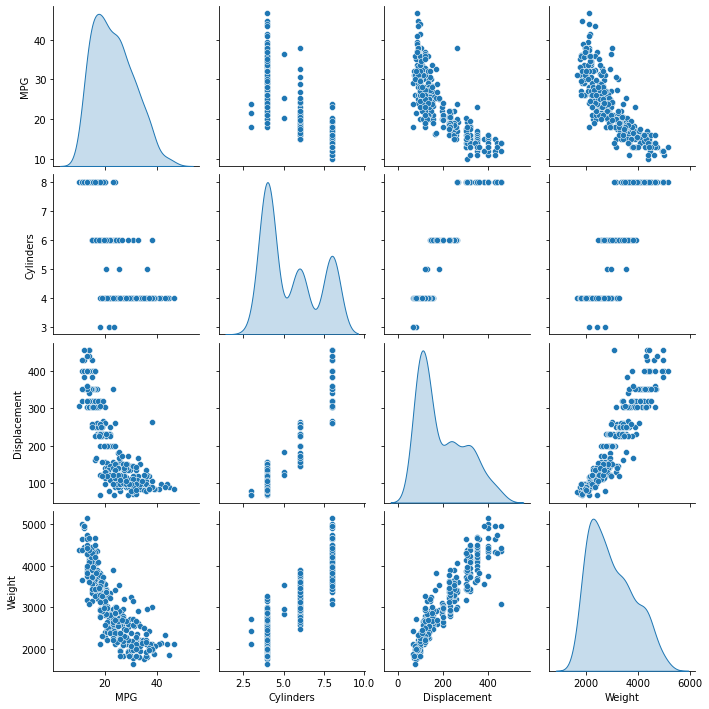

In [41]:
sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde')

Repare na visão geral das estatísticas:

In [42]:
train_stats = train_dataset.describe()
train_stats.pop('MPG')
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


### Separe features de labels

Separe o valor alvo (*labels*), das features. Esta label é o valor no qual o modelo é treinado para prever.

In [43]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

### Normalize os dados

Olhe novamente para o bloco **`train_stats`** acima e note quão diferente é a variação de feature.

Uma boa prática é normalizar as *features* que usam diferentes escalas e intervalos. Apesar do modelo poder convergir sem a normalização, isso torna o treinamento mais difícil, e o resultado do modelo dependente da escolha das unidades de entrada.

In [44]:
def norm(x):
  return (x - train_stats['mean'])/train_stats['std']

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

O dado normalizado é o que nós usaremos para treinar o modelo.

**Atenção**: A estatística usada para normalizar as entradas aqui (média e desvio padrão) precisa ser aplicada em qualquer outro dado que alimenta o modelo, junto com a condificação *one-hot* que fizemos anteriormente. Isso inclui o conjunto de teste, assim como os dados que o modelo usará em produção.

## O Modelo

### Construindo o modelo

Vamos construir o modelo. Aqui usaremos o modelo `Sequential` com duas camadas *densely connected*(completamente conectadas), e a camada de saída que retorna um único valor contínuo. Os passos de construção do modelo são agrupados em uma função, `build_model`, já que criaremos um segundo modelo mais tarde.

In [45]:
def build_model():
  model = keras.Sequential([
                           layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
                           layers.Dense(64, activation='relu'),
                           layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [46]:
model = build_model()

### Examine o modelo

Use o método `.summary` para exibir uma descrição simples do modelo.

In [47]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 64)                640       
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


Agora teste o modelo. Pegue um batch de 10 exemplos do conjunto de treinamento e chame `model.predict`.

In [48]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[ 0.48333117],
       [ 0.03885733],
       [-0.10828911],
       [ 0.22597007],
       [ 0.36553174],
       [-0.02771195],
       [ 0.34122953],
       [-0.10749023],
       [-0.05767351],
       [ 0.41032773]], dtype=float32)

Parece que está funcionando e ele produz o resultado de forma e tipo esperados.

### Treinando o modelo

Treine o modelo com 1000 épocas, e grave a acurácia do treinamento e da validação em um onjeto `history`.

In [49]:
history = model.fit(
    normed_train_data, train_labels,
    epochs=1000, validation_split=0.2, verbose=1)

Epoch 1/1000
8/8 [==============================] - 0s 18ms/step - loss: 559.4042 - mae: 22.4564 - mse: 559.4042 - val_loss: 551.5887 - val_mae: 22.2947 - val_mse: 551.5887
Epoch 2/1000
8/8 [==============================] - 0s 4ms/step - loss: 507.5626 - mae: 21.3673 - mse: 507.5626 - val_loss: 495.6733 - val_mae: 21.0935 - val_mse: 495.6733
Epoch 3/1000
8/8 [==============================] - 0s 3ms/step - loss: 454.3885 - mae: 20.1581 - mse: 454.3885 - val_loss: 436.1595 - val_mae: 19.7112 - val_mse: 436.1595
Epoch 4/1000
8/8 [==============================] - 0s 3ms/step - loss: 396.0215 - mae: 18.7399 - mse: 396.0215 - val_loss: 369.5404 - val_mae: 18.0423 - val_mse: 369.5404
Epoch 5/1000
8/8 [==============================] - 0s 3ms/step - loss: 333.1198 - mae: 17.0679 - mse: 333.1198 - val_loss: 299.8284 - val_mae: 16.1116 - val_mse: 299.8284
Epoch 6/1000
8/8 [==============================] - 0s 3ms/step - loss: 268.2729 - mae: 15.1589 - mse: 268.2729 - val_loss: 231.8850 - val_

Visualize o progresso do modelo de treinamento usando os estados armazenados no objeto `history`

In [50]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,2.831383,1.089699,2.831383,11.309529,2.545530,11.309529,995
996,2.596737,1.094568,2.596737,11.046123,2.480128,11.046123,996
997,2.744481,1.069669,2.744481,10.958874,2.484052,10.958874,997
998,2.588399,1.080856,2.588399,10.806558,2.471273,10.806558,998
999,2.634868,1.055669,2.634868,10.919705,2.466554,10.919705,999


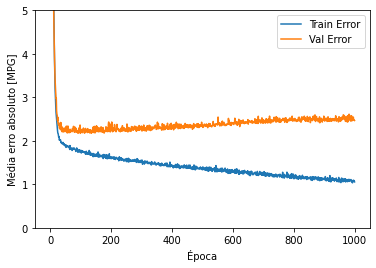

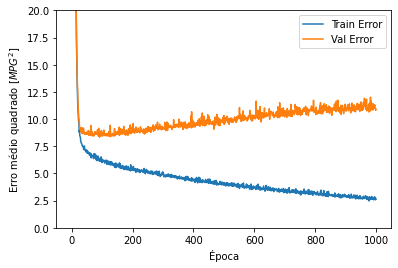

In [51]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Época')
  plt.ylabel('Média erro absoluto [MPG]')
  plt.plot(hist['epoch'], hist['mae'], label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'], label='Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Época')
  plt.ylabel('Erro médio quadrado [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mse'], label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'], label='Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()

plot_history(history)

Este grafo mostra as pequenas melhoras, ou mesmo a diminuição do `validation error` após 100 épocas. Vamos atualizar o `model.fit` para que pare automaticamente o treinamento quando o `validation score` não aumentar mais. Usaremos o `EarlyStopping callback` que esta a condição do treinamento a cada `epoch`. Se um grupo de `epochs` decorre sem mostrar melhoras, o treinamento irá parar automaticamente.

Epoch 1/1000
8/8 [==============================] - 0s 19ms/step - loss: 568.0292 - mae: 22.5222 - mse: 568.0292 - val_loss: 550.2452 - val_mae: 22.1193 - val_mse: 550.2452
Epoch 2/1000
8/8 [==============================] - 0s 3ms/step - loss: 507.7133 - mae: 21.1846 - mse: 507.7133 - val_loss: 488.0003 - val_mae: 20.7163 - val_mse: 488.0003
Epoch 3/1000
8/8 [==============================] - 0s 3ms/step - loss: 451.0223 - mae: 19.8608 - mse: 451.0223 - val_loss: 423.4315 - val_mae: 19.1635 - val_mse: 423.4315
Epoch 4/1000
8/8 [==============================] - 0s 3ms/step - loss: 389.7686 - mae: 18.3561 - mse: 389.7686 - val_loss: 353.5698 - val_mae: 17.3567 - val_mse: 353.5698
Epoch 5/1000
8/8 [==============================] - 0s 3ms/step - loss: 325.1056 - mae: 16.6236 - mse: 325.1056 - val_loss: 283.6001 - val_mae: 15.3445 - val_mse: 283.6001
Epoch 6/1000
8/8 [==============================] - 0s 3ms/step - loss: 261.4028 - mae: 14.6922 - mse: 261.4028 - val_loss: 217.4426 - val_

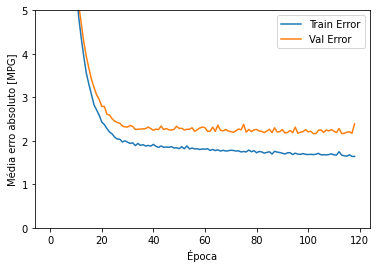

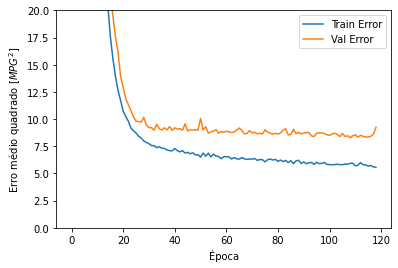

In [52]:
model = build_model()

# O parâmetro "patience" é a quantidade de épocas para checar as melhoras
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=1000,
                    validation_split=0.2, verbose=1, callbacks=early_stop)

plot_history(history)

O gráfico mostra que no conjunto de validação, a média de erro é proximo de 2MPG. Isso é bom?
Deixaremos essa decisão a você.

Vamos ver quão bem o modelo generaliza usando o conjunto de **teste**, que não usamos para treinar o modelo. Isso diz quão bem podemos esperar que o modelo se saia quando usarmos na vida real.

In [55]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print(f'Erro absoluto médio do conjunto de teste: {mae:5.2f}')

3/3 - 0s - loss: 6.0927 - mae: 1.7962 - mse: 6.0927
Erro absoluto médio do conjunto de teste:  1.80


### Facça predições

Finalmente, preveremos os valores MPG usando o conjunto de teste

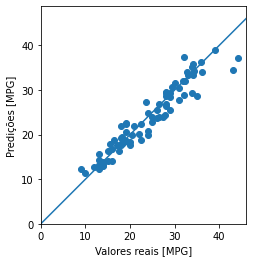

In [56]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('Valores reais [MPG]')
plt.ylabel('Predições [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0, plt.xlim()[1]])
plt.ylim([0, plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

Parec que o nosso modelo prediz razoavelmente bem. Vamos dar uma olhada na distribuição dos erros.

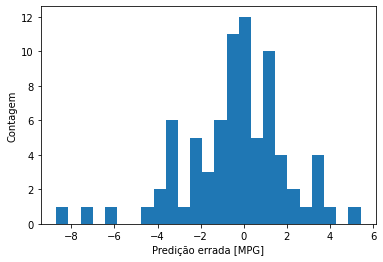

In [57]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Predição errada [MPG]')
_ = plt.ylabel('Contagem')

Não é tão gaussiana, porém podemos esperar que por conta do número de exemplos ser bem pequeno.

## Conclusão

Este notebook introduz algumas técnicas para trabalhar com problemas de regressão.

* Mean Squared Error (MSE), é uma função comum da perda (loss) usada para problemas de regressão (diferentes funções de *loss* são usadas para problemas de classificação)

* Similarmente, as métricas de evolução usadas na regressão são diferentes da classificação. Uma métrica comum de regressão é a Mean Absolute Error (MAE).

* Quando o dado de entrada (*features*) tem diferentes intervalos, cada *feature* deve ser escalada para o mesmo intervalo. (processos de normalização).

* Se não possuir muitos dados de treinamento, uma técnica é preferir uma pequena rede com poucas camada para evitar *overfitting*.

* *Early stopping* é uma boa técnica para evitar *overfitting*.

In [58]:
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.